(ex-tensorflow-tn-opt)=

# Optimizing a Tensor Network using Tensorflow

In this example we show how a general machine learning
strategy can be used to optimize arbitrary tensor networks
with respect to any target loss function.

We'll take the example of maximizing the overlap of some
matrix product state with periodic boundary conditions
with a densely represented state, since this does not
have a simple, deterministic alternative.

`quimb` makes use of `opt_einsum` which can contract
tensors with a variety of backends as well as `autoray`
for handling array operations agnostically. Here we'll use
`tensorflow-v2` for the actual auto-gradient computation.

In [1]:
%config InlineBackend.figure_formats = ['svg']

import quimb as qu
import quimb.tensor as qtn
from quimb.tensor.optimize import TNOptimizer

First, find a (dense) PBC groundstate, $| gs \rangle$:

In [2]:
L = 16
H = qu.ham_heis(L, sparse=True, cyclic=True)
gs = qu.groundstate(H)

Then we convert it to a dense 1D 'tensor network':

In [3]:
# this converts the dense vector to an effective 1D tensor network (with only one tensor)
target = qtn.Dense1D(gs)
print(target)

Dense1D([
    Tensor(shape=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2), inds=('k0', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8', 'k9', 'k10', 'k11', 'k12', 'k13', 'k14', 'k15'), tags=('I0', 'I1', 'I2', 'I3', 'I4', 'I5', 'I6', 'I7', 'I8', 'I9', 'I10', 'I11', 'I12', 'I13', 'I14', 'I15')),
], structure='I{}', nsites=16)


Next we create an initial guess random MPS, $|\psi\rangle$:

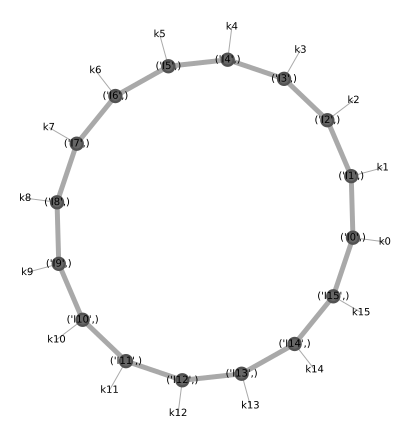

In [4]:
bond_dim = 32
mps = qtn.MPS_rand_state(L, bond_dim, cyclic=True)
mps.draw()

We now need to set-up the function that 'prepares' our tensor network. 
In the current example this involves making sure the state is always normalized.

In [5]:
def normalize_state(psi):
    return psi / (psi.H @ psi) ** 0.5

Then we need to set-up our 'loss' function, the function that returns 
the scalar quantity we want to minimize.

In [6]:
def negative_overlap(psi, target):
    return - (psi.H @ target) ** 2  # minus so as to minimize

Now we can set up the tensor network optimizer object:

In [7]:
optmzr = TNOptimizer(
    mps,                                # our initial input, the tensors of which to optimize
    loss_fn=negative_overlap,
    norm_fn=normalize_state,
    loss_constants={'target': target},  # this is a constant TN to supply to loss_fn
    autodiff_backend='tensorflow',      # {'jax', 'tensorflow', 'autograd'}
    optimizer='L-BFGS-B',               # supplied to scipy.minimize
)

Then we are ready to optimize our tensor network! Note how we supplied the constant tensor network ``target`` - its tensors will not be changed.

In [8]:
mps_opt = optmzr.optimize(100)  # perform ~100 gradient descent steps

-0.9998071635857917: 100%|██████████| 100/100 [00:06<00:00, 16.52it/s]


The output optimized (and normalized) tensor netwwork has already been converted back to numpy:

In [9]:
type(mps_opt[0].data)

numpy.ndarray

And we can explicitly check the returned state indeed matches the loss shown above:

In [10]:
((mps_opt.H & target) ^ all) ** 2

0.9998071635857877

Other things to think about might be:

- try other scipy optimizers for the `optimizer=` option
- try other autodiff backends for the `autodiff_backend=` option
    * ``'jax'`` - likely the best performance but slow to compile the initial computation
    * ``'autograd'`` - numpy based, cpu-only optimization
    * ``'torch'`` - (pytorch), quick compilation and decent performance, though no complex support (yet?)
- using single precision data for better GPU acceleration


We can also keep optimizing:

In [11]:
mps_opt = optmzr.optimize(100)  # perform another ~100 gradient descent steps

-0.9999381547713172: 100%|██████████| 100/100 [00:05<00:00, 19.71it/s]
